#### Artem Golotin
CS501R Lab 5

In [1]:
import tensorflow as tf

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Placeholders for data
I, O = 784, 10
x = tf.placeholder(tf.float32, shape=[None, I], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, O], name='output')
# Reshape the input image to match the first convolutional input dimentions
x_image = tf.reshape(x, [-1,28,28,1]) # 28 - width, 28 - height, 1 - color channels


### Convolutional and max pooling functions
conv2d = lambda x, W: tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
max_pool_2x2 = lambda x: tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### First convolutional layer
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))

# Convolve x_image with the weight tensor + bias, normalize the batch, apply ReLU and max pool
h_conv1 = conv2d(x_image, W_conv1) + b_conv1
h_mean1, h_var1 = tf.nn.moments(h_conv1, [0, 1, 2, 3])
h_norm1 = tf.nn.batch_normalization(h_conv1, h_mean1, h_var1, None, None, variance_epsilon=1e-3)
h_relu1 = tf.nn.relu(h_norm1)
h_pool1 = max_pool_2x2(h_relu1)

### Second convolutional layer
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

# Convolve h_pool1 with the weight tensor + bias, normalize the batch, apply ReLU and max pool
h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
h_mean2, h_var2 = tf.nn.moments(h_conv2, [0, 1, 2, 3])
h_norm2 = tf.nn.batch_normalization(h_conv2, h_mean2, h_var2, None, None, variance_epsilon=1e-3)
h_relu2 = tf.nn.relu(h_norm2)
h_pool2 = max_pool_2x2(h_relu2)

### Fully connected layer
W_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
# Reshape the tensor from last pooling layer to a batch of vectors
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout layer to avoid overfitting and to calculate correct training accuracy
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer and final output
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
# Compute final output
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_pred), reduction_indices=[1]))
# Training function
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, epsilon=1e-4).minimize(cross_entropy)
# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
from tqdm import tqdm
import numpy as np

accuracies = []
# Run the session
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for epoch in tqdm(range(1001)):
        # Get next batch
        batch_x, batch_y = mnist.train.next_batch(100)
        grayscaled_x = np.apply_along_axis(np.subtract, 0, batch_x, np.average(batch_x, axis=1))
        train_x, train_y = np.vstack((batch_x, grayscaled_x)), np.vstack((batch_y, batch_y))
        # Train
        sess.run(train_step, feed_dict={x: train_x, y_: train_y, keep_prob: 0.5})
        # Get accuracy every 5 epochs (it's sooooo slow on CPU)
        if epoch % 5 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            accuracies.append(train_accuracy)


100%|██████████| 1001/1001 [3:02:13<00:00, 16.81s/it]


In [4]:
import matplotlib.pyplot as plt

def plot_accuracy():
    x = range(0, 1001, 5)
    plt.axhline(y=0.9, color='r', ls='dashed', label='90% Cutoff')
    plt.plot(x, accuracies)
    plt.ylabel("Classification Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(loc='best')
    plt.show()


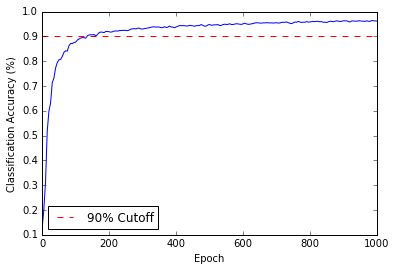

In [5]:
%matplotlib inline
plot_accuracy()